**Notebook 2**

For this section I will be using 2018 flights, and joing the airports data so we can have cleaner and more concise visualisation

In [1]:
flightPerfFilePath = "/ca2/2018.csv"

#Obtain Departure Delays dataset
flightPerf = spark.read.csv(flightPerfFilePath, header='true')
flightPerf.createOrReplaceTempView("FlightPerformance")

#Cache the Departure Delays dataset 
#flightPerf.cache()

In [2]:
airportInfo = "/ca2/airport.csv"

airportI = spark.read.csv(airportInfo, header='true')
airportI.createOrReplaceTempView("FlightAirports")

#Cache the Departure Delays dataset 
#airportI.cache()

In [18]:
airportI.show(5)

+----+--------------------+----------------+-----+-------+-----------+------------+
|iata|             airport|            city|state|country|        lat|        long|
+----+--------------------+----------------+-----+-------+-----------+------------+
| 00M|            Thigpen |     Bay Springs|   MS|    USA|31.95376472|-89.23450472|
| 00R|Livingston Municipal|      Livingston|   TX|    USA|30.68586111|-95.01792778|
| 00V|         Meadow Lake|Colorado Springs|   CO|    USA|38.94574889|-104.5698933|
| 01G|        Perry-Warsaw|           Perry|   NY|    USA|42.74134667|-78.05208056|
| 01J|    Hilliard Airpark|        Hilliard|   FL|    USA| 30.6880125|-81.90594389|
+----+--------------------+----------------+-----+-------+-----------+------------+
only showing top 5 rows



**Inner join** 

This is the default join in PySpark and it’s mostly used. This joins two datasets on key columns, where keys don’t match the rows get dropped from both datasets (emp & dept)

In [3]:
inner_join = flightPerf.join(airportI, flightPerf.ORIGIN == airportI.iata)
inner_join.show()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+----+--------------------+----------+-----+-------+-----------+------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|iata|             airport|      city|state|country|        lat|        long|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------

In [4]:
inner_join.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

In [4]:
from pyspark.sql import functions as F 
from pyspark.sql.types import DoubleType, IntegerType, StringType, TimestampType, BinaryType

In [5]:
inner_join = inner_join.withColumn('DISTANCE', F.col('DISTANCE').cast(IntegerType()))

In [38]:
hists = inner_join.select('DISTANCE').rdd.flatMap(lambda row: row).histogram(20)

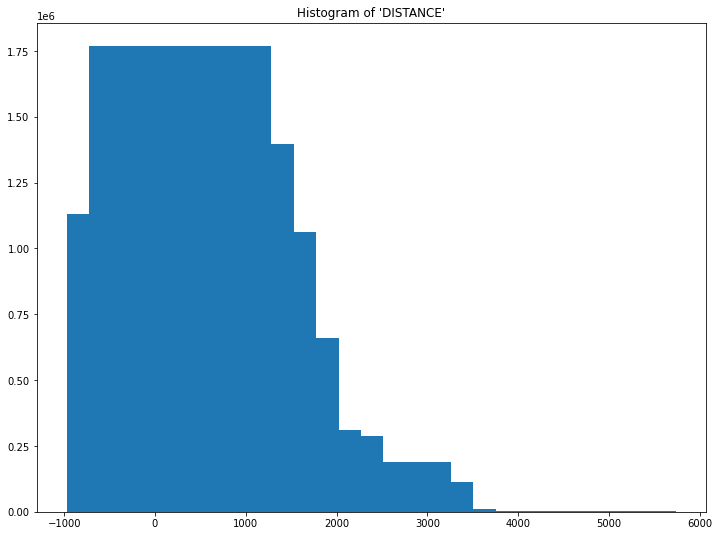

In [43]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'DISTANCE\'')

plt.savefig('B05793_05_22.png', dpi=300)

In [6]:
#Selecting the data that i want to use for analysis

inner_join = inner_join.select('FL_DATE','OP_CARRIER','ORIGIN','CANCELLED','WEATHER_DELAY','ARR_DELAY','iata','airport','city','state','country','lat','long')
inner_join.show()

+----------+----------+------+---------+-------------+---------+----+--------------------+----------+-----+-------+-----------+------------+
|   FL_DATE|OP_CARRIER|ORIGIN|CANCELLED|WEATHER_DELAY|ARR_DELAY|iata|             airport|      city|state|country|        lat|        long|
+----------+----------+------+---------+-------------+---------+----+--------------------+----------+-----+-------+-----------+------------+
|2018-01-01|        UA|   EWR|      0.0|         null|    -23.0| EWR|         Newark Intl|    Newark|   NJ|    USA|40.69249722|-74.16866056|
|2018-01-01|        UA|   LAS|      0.0|         null|    -24.0| LAS|McCarran Internat...| Las Vegas|   NV|    USA|36.08036111|-115.1523333|
|2018-01-01|        UA|   SNA|      0.0|         null|    -13.0| SNA|John Wayne /Orang...| Santa Ana|   CA|    USA|33.67565861|-117.8682225|
|2018-01-01|        UA|   RSW|      0.0|         null|     -2.0| RSW|Southwest Florida...| Ft. Myers|   FL|    USA|26.53616667|-81.75516667|
|2018-01-01| 

In [10]:
inner_join.groupBy(["state"]).agg(F.sum("CANCELLED") ,F.max("CANCELLED")).show(50)

+-----+--------------+--------------+
|state|sum(CANCELLED)|max(CANCELLED)|
+-----+--------------+--------------+
|   AZ|        1474.0|           1.0|
|   SC|        1727.0|           1.0|
|   LA|        1128.0|           1.0|
|   MN|        1820.0|           1.0|
|   NJ|        4758.0|           1.0|
|   OR|         549.0|           1.0|
|   NA|         108.0|           1.0|
|   VA|        6857.0|           1.0|
|   RI|         553.0|           1.0|
|   KY|        1660.0|           1.0|
|   WY|          72.0|           1.0|
|   NH|         343.0|           1.0|
|   MI|        2405.0|           1.0|
|   NV|        1250.0|           1.0|
|   WI|        1139.0|           1.0|
|   ID|         213.0|           1.0|
|   CA|        8099.0|           1.0|
|   CT|         761.0|           1.0|
|   NE|         436.0|           1.0|
|   MT|          88.0|           1.0|
|   NC|        9121.0|           1.0|
|   VT|         384.0|           1.0|
|   MD|        2320.0|           1.0|
|   MO|     

In [68]:
inner_join.count()

7200636

In [63]:
inner_join.select("OP_CARRIER", "CANCELLED").filter("CANCELLED = 1").show(3)

+----------+---------+
|OP_CARRIER|CANCELLED|
+----------+---------+
|        UA|      1.0|
|        UA|      1.0|
|        UA|      1.0|
+----------+---------+
only showing top 3 rows



In [62]:
inner_join.groupBy('CANCELLED').count().show()

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      1.0| 116365|
|      0.0|7084271|
+---------+-------+



In [11]:
#using the same methodolgy as notebook one to create day, month, year

from pyspark.sql.functions import *
from pyspark.sql.functions import year, month, dayofweek
inner_join = inner_join.withColumn('dayOfWeek', dayofweek(col('FL_DATE')))
inner_join = inner_join.withColumn('month', month(col('FL_DATE')))
inner_join = inner_join.withColumn('year', year(col('FL_DATE')))

In [12]:
inner_join.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- WEATHER_DELAY: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- dayOfWeek: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [16]:
#Selecting my columns

inner_join = inner_join.select('dayOfWeek','month','year','OP_CARRIER','ORIGIN','CANCELLED','ARR_DELAY','WEATHER_DELAY','iata','airport','city','state','country','lat','long')
inner_join.show()

+---------+-----+----+----------+------+---------+---------+-------------+----+--------------------+----------+-----+-------+-----------+------------+
|dayOfWeek|month|year|OP_CARRIER|ORIGIN|CANCELLED|ARR_DELAY|WEATHER_DELAY|iata|             airport|      city|state|country|        lat|        long|
+---------+-----+----+----------+------+---------+---------+-------------+----+--------------------+----------+-----+-------+-----------+------------+
|        2|    1|2018|        UA|   EWR|        0|    -23.0|         null| EWR|         Newark Intl|    Newark|   NJ|    USA|40.69249722|-74.16866056|
|        2|    1|2018|        UA|   LAS|        0|    -24.0|         null| LAS|McCarran Internat...| Las Vegas|   NV|    USA|36.08036111|-115.1523333|
|        2|    1|2018|        UA|   SNA|        0|    -13.0|         null| SNA|John Wayne /Orang...| Santa Ana|   CA|    USA|33.67565861|-117.8682225|
|        2|    1|2018|        UA|   RSW|        0|     -2.0|         null| RSW|Southwest Flori

In [17]:
from pyspark.sql.types import DoubleType, IntegerType, StringType, TimestampType, BinaryType

In [18]:
from pyspark.sql import functions as F 

In [19]:
#'dayOfWeek','month','year','OP_CARRIER','ORIGIN','CANCELLED','iata','airport','city','state','country','lat','long'
#converting datatypes where required using cast method

inner_join = inner_join.withColumn('dayOfWeek', F.col('dayOfWeek').cast(IntegerType()))
inner_join = inner_join.withColumn('month', F.col('month').cast(IntegerType()))
inner_join = inner_join.withColumn('year', F.col('year').cast(IntegerType()))
inner_join = inner_join.withColumn('CANCELLED', F.col('CANCELLED').cast(IntegerType()))
inner_join = inner_join.withColumn('WEATHER_DELAY', F.col('WEATHER_DELAY').cast(IntegerType()))
inner_join = inner_join.withColumn('ARR_DELAY', F.col('ARR_DELAY').cast(IntegerType()))

In [20]:
inner_join.show(5)

+---------+-----+----+----------+------+---------+---------+-------------+----+--------------------+---------+-----+-------+-----------+------------+
|dayOfWeek|month|year|OP_CARRIER|ORIGIN|CANCELLED|ARR_DELAY|WEATHER_DELAY|iata|             airport|     city|state|country|        lat|        long|
+---------+-----+----+----------+------+---------+---------+-------------+----+--------------------+---------+-----+-------+-----------+------------+
|        2|    1|2018|        UA|   EWR|        0|      -23|         null| EWR|         Newark Intl|   Newark|   NJ|    USA|40.69249722|-74.16866056|
|        2|    1|2018|        UA|   LAS|        0|      -24|         null| LAS|McCarran Internat...|Las Vegas|   NV|    USA|36.08036111|-115.1523333|
|        2|    1|2018|        UA|   SNA|        0|      -13|         null| SNA|John Wayne /Orang...|Santa Ana|   CA|    USA|33.67565861|-117.8682225|
|        2|    1|2018|        UA|   RSW|        0|       -2|         null| RSW|Southwest Florida...|

In [48]:
inner_join.groupBy(["state"]).agg(F.sum("CANCELLED") ,F.max("CANCELLED")).show(58)


+-----+--------------+--------------+
|state|sum(CANCELLED)|max(CANCELLED)|
+-----+--------------+--------------+
|   AZ|          1474|             1|
|   SC|          1727|             1|
|   LA|          1128|             1|
|   MN|          1820|             1|
|   NJ|          4758|             1|
|   OR|           549|             1|
|   NA|           108|             1|
|   VA|          6857|             1|
|   RI|           553|             1|
|   WY|            72|             1|
|   KY|          1660|             1|
|   NH|           343|             1|
|   MI|          2405|             1|
|   NV|          1250|             1|
|   WI|          1139|             1|
|   ID|           213|             1|
|   CA|          8099|             1|
|   CT|           761|             1|
|   NE|           436|             1|
|   MT|            88|             1|
|   NC|          9121|             1|
|   VT|           384|             1|
|   MD|          2320|             1|
|   MO|     

In [23]:
inner_join.printSchema()

root
 |-- dayOfWeek: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- WEATHER_DELAY: integer (nullable = true)
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



In [14]:
#one second thoughts we will go with binary cancellation only
inner_join = inner_join.select('dayOfWeek','month','year','OP_CARRIER','ORIGIN','CANCELLED','iata','airport','city','state','country','lat','long')
inner_join.show()

+---------+-----+----+----------+------+---------+----+--------------------+----------+-----+-------+-----------+------------+
|dayOfWeek|month|year|OP_CARRIER|ORIGIN|CANCELLED|iata|             airport|      city|state|country|        lat|        long|
+---------+-----+----+----------+------+---------+----+--------------------+----------+-----+-------+-----------+------------+
|        2|    1|2018|        UA|   EWR|        0| EWR|         Newark Intl|    Newark|   NJ|    USA|40.69249722|-74.16866056|
|        2|    1|2018|        UA|   LAS|        0| LAS|McCarran Internat...| Las Vegas|   NV|    USA|36.08036111|-115.1523333|
|        2|    1|2018|        UA|   SNA|        0| SNA|John Wayne /Orang...| Santa Ana|   CA|    USA|33.67565861|-117.8682225|
|        2|    1|2018|        UA|   RSW|        0| RSW|Southwest Florida...| Ft. Myers|   FL|    USA|26.53616667|-81.75516667|
|        2|    1|2018|        UA|   ORD|        0| ORD|Chicago O'Hare In...|   Chicago|   IL|    USA|  41.97959

In [16]:
#I tried to use UDF to view the high and low cancellations

import pyspark.sql.functions as F
from pyspark.sql.types import *
def casesHighLow(CANCELLED):
    if CANCELLED < 1 : 
        return 'high'
    else:
        return 'low'
    
#convert to a UDF Function by passing in the function and return type of function
casesHighLowUDF = F.udf(casesHighLow, IntegerType())
CasesWithHighLow = inner_join.withColumn("HighLow", casesHighLowUDF("CANCELLED"))
CasesWithHighLow.show(3)

+---------+-----+----+----------+------+---------+----+--------------------+---------+-----+-------+-----------+------------+-------+
|dayOfWeek|month|year|OP_CARRIER|ORIGIN|CANCELLED|iata|             airport|     city|state|country|        lat|        long|HighLow|
+---------+-----+----+----------+------+---------+----+--------------------+---------+-----+-------+-----------+------------+-------+
|        2|    1|2018|        UA|   EWR|        0| EWR|         Newark Intl|   Newark|   NJ|    USA|40.69249722|-74.16866056|   null|
|        2|    1|2018|        UA|   LAS|        0| LAS|McCarran Internat...|Las Vegas|   NV|    USA|36.08036111|-115.1523333|   null|
|        2|    1|2018|        UA|   SNA|        0| SNA|John Wayne /Orang...|Santa Ana|   CA|    USA|33.67565861|-117.8682225|   null|
+---------+-----+----+----------+------+---------+----+--------------------+---------+-----+-------+-----------+------------+-------+
only showing top 3 rows



In [ ]:
inner_join.show(5)

**PySpark Window functions** 

Used to calculate results such as the rank, row number e.t.c over a range of input rows. In this article, I’ve explained the concept of window functions, syntax, and finally how to use them with PySpark SQL and PySpark DataFrame API. These come in handy when we need to make aggregate operations in a specific window frame on DataFrame columns.

In [27]:
#from pyspark.sql.window import Window

#windowSpec = Window().partitionBy(['state']).orderBy(F.desc('CANCELLED'))
#inner_join.withColumn("rank",F.rank().over(windowSpec)).show()

Sometimes we may need to have the dataframe in flat format. This happens frequently in movie data where we may want to show genres as columns instead of rows. We can use pivot to do this. Here I am trying to get one row for each date and getting the province names as columns.


In [25]:
pivotedCancelled = inner_join.groupBy('month').pivot('state').agg(F.sum('CANCELLED').alias('CANCELLED'))
pivotedCancelled.limit(10).toPandas()

,month,AK,AL,AR,AS,AZ,CA,CO,CT,FL,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,12,53,60,44,0,135,644,198,19,330,...,99,1214,27,322,2,10,30,47,12,7
1,1,55,122,79,0,145,863,297,144,1139,...,309,1871,81,878,3,56,122,113,31,11
2,6,35,134,62,0,94,567,167,63,562,...,216,878,25,715,0,24,51,140,40,6
3,3,38,37,38,0,126,1093,246,245,1267,...,253,883,31,1384,2,93,72,101,17,15
4,5,23,30,34,0,86,656,127,51,404,...,114,732,21,546,1,19,37,64,21,0
5,9,6,66,41,0,133,539,122,17,299,...,116,1181,20,472,0,11,71,68,17,2
6,4,15,42,26,0,105,565,136,27,308,...,102,531,28,277,0,26,31,144,6,5
7,8,31,62,29,0,176,1003,200,39,553,...,205,908,28,773,0,46,108,150,12,8
8,7,22,56,38,0,184,731,445,50,798,...,194,915,37,621,1,40,66,78,13,5
9,10,29,49,19,0,67,444,77,11,263,...,70,943,13,198,1,9,91,32,9,2


In [33]:
pivotedCancelled.toPandas()

,month,AK,AL,AR,AS,AZ,CA,CO,CT,FL,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,12,53,60,44,0,135,644,198,19,330,...,99,1214,27,322,2,10,30,47,12,7
1,1,55,122,79,0,145,863,297,144,1139,...,309,1871,81,878,3,56,122,113,31,11
2,6,35,134,62,0,94,567,167,63,562,...,216,878,25,715,0,24,51,140,40,6
3,3,38,37,38,0,126,1093,246,245,1267,...,253,883,31,1384,2,93,72,101,17,15
4,5,23,30,34,0,86,656,127,51,404,...,114,732,21,546,1,19,37,64,21,0
5,9,6,66,41,0,133,539,122,17,299,...,116,1181,20,472,0,11,71,68,17,2
6,4,15,42,26,0,105,565,136,27,308,...,102,531,28,277,0,26,31,144,6,5
7,8,31,62,29,0,176,1003,200,39,553,...,205,908,28,773,0,46,108,150,12,8
8,7,22,56,38,0,184,731,445,50,798,...,194,915,37,621,1,40,66,78,13,5
9,10,29,49,19,0,67,444,77,11,263,...,70,943,13,198,1,9,91,32,9,2


**Observation regarding memory**

When you work with Spark you will frequently run with memory and storage issues. While in some cases such issues might be resolved using techniques like broadcasting, salting or cache, sometimes just interrupting the workflow and saving and reloading the whole dataframe at a crucial step has helped me a lot. This helps spark to let go of a lot of memory that gets utilized for storing intermediate shuffle data and unused caches.

See below: already exists from previous notebook - no need to run again as it's already in memory but in memory, when i ran again I received this error; *AnalysisException: path hdfs://localhost:9000/user/hduser/data/inner_join.parquet already exists*

In [18]:
#inner_join.write.parquet("data/inner_join.parquet")
#spark.read.load("data/inner_join.parquet")

**Numerical Correlations**

completed numerical corr on my chosen data with little success or observations gained, It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. 

In [19]:
 numerical = ['dayOfWeek','month','year','CANCELLED','WEATHER_DELAY']# maybe add weather delay!!!!!!

In [20]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(inner_join.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0,
  -0.0007479533864901083,
  nan,
  0.0002052680900963403,
  -4.428535297648181e-06],
 [None, 1.0, nan, -0.03552534290441702, -0.0015441049552425735],
 [None, None, nan, nan, nan],
 [None, None, None, 1.0, -0.006687091965827256],
 [None, None, None, None, 1.0]]

In [45]:
pip install OneHotEncoder

ERROR: Could not find a version that satisfies the requirement OneHotEncoder (from versions: none)
ERROR: No matching distribution found for OneHotEncoder
Note: you may need to restart the kernel to use updated packages.


**Preparing Data for Machine Learning**

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column. Same mthodology as notebook 1

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [17]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler 

categoricalColumns = ['OP_CARRIER', 'iata', 'airport', 'city']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'state', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['CANCELLED','month']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [18]:
cols = inner_join.columns

In [19]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(inner_join)
inner_join = pipelineModel.transform(inner_join)
selectedCols = ['label', 'features'] + cols
inner_join = inner_join.select(selectedCols)
inner_join.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- dayOfWeek: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



**Train & Test**

Randomly split data into train and test sets, and set seed for reproducibility.

In [20]:
train, test = inner_join.randomSplit([0.7, 0.3], seed = 12345)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 5040674
Test Dataset Count: 2159962


In [21]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

**Make predictions on the test set**

In [25]:
predictions = lrModel.transform(test)
predictions.select('city', 'CANCELLED', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+---------+-----+--------------------+----------+--------------------+
|       city|CANCELLED|label|       rawPrediction|prediction|         probability|
+-----------+---------+-----+--------------------+----------+--------------------+
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los Angeles|        1|  0.0|[13.0950776819797...|       0.0|[0.99981846207635...|
|Los

**Evaluate our Logistic Regression model**

Test Area Under ROC 0.9999990740475541

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Exception ignored in: <function JavaWrapper.__del__ at 0x7fad477a4550>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7fad477a4550>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


Test Area Under ROC 0.9999990740475541
